In [31]:
import tensorflow as tf
import numpy as np
import os
import cv2
import imghdr
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

In [32]:
!pwd

/content


In [33]:
data_dir= "/gdrive/MyDrive/Dataset"
image_classes = os.listdir(data_dir)
image_classes

['ba', 'ca']

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [36]:
image_exts = ['jpeg','jpg','bmp','png']

In [37]:
len(tf.config.list_physical_devices('GPU'))

1

In [38]:
for image_class in image_classes:
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      # plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print(f"Image not in ext list {image_path}")
        os.remove(image_path)
    except Exception as e:
      print(f"Issue with image {image_path}")

In [39]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 180 files belonging to 2 classes.


In [40]:
data = data.map(lambda x,y : (x/255, y))

In [41]:
scaled_iterator = data.as_numpy_iterator()

In [42]:
batch = scaled_iterator.next()

In [43]:
len(data)

6

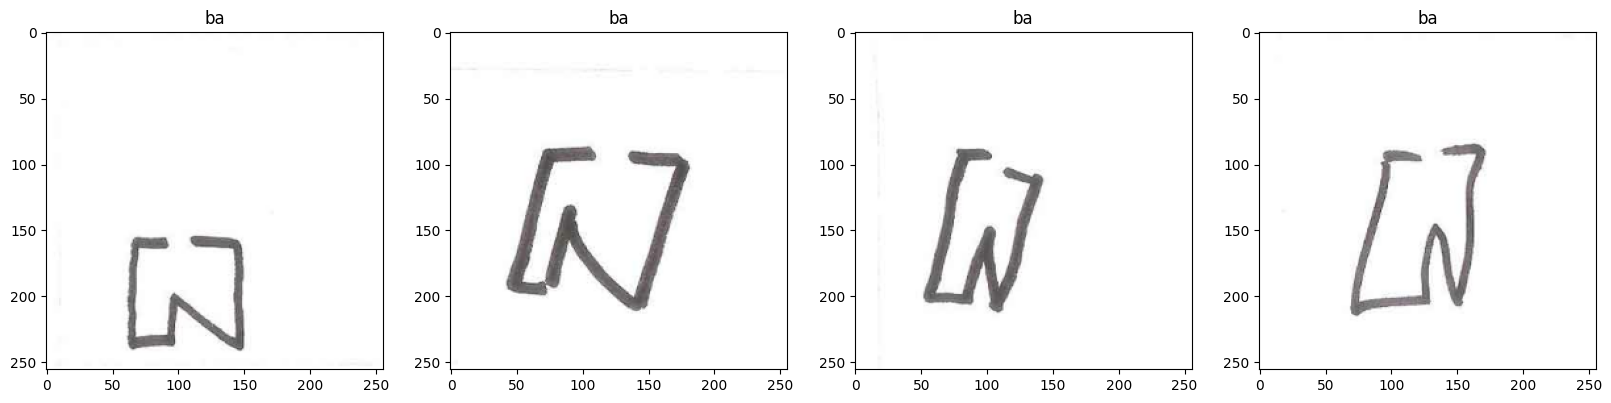

In [44]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text("ba" if batch[1][idx]==0 else "ca")

In [45]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

print(f"train size = {train_size}")
print(f"val size = {val_size}")
print(f"test size = {test_size}")

train size = 4
val size = 2
test size = 1


In [46]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [47]:
model = Sequential()

model.add(Conv2D(16,(3,3),1,activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [50]:
logdir='logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [52]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 8s 529ms/step - loss: 1.0376 - accuracy: 0.5234 - val_loss: 0.7490 - val_accuracy: 0.4231
Epoch 2/20
4/4 [==============================] - 1s 151ms/step - loss: 0.7085 - accuracy: 0.4922 - val_loss: 0.6887 - val_accuracy: 0.5192
Epoch 3/20
4/4 [==============================] - 1s 144ms/step - loss: 0.6946 - accuracy: 0.4844 - val_loss: 0.6785 - val_accuracy: 0.8269
Epoch 4/20
4/4 [==============================] - 1s 252ms/step - loss: 0.6719 - accuracy: 0.7109 - val_loss: 0.6681 - val_accuracy: 0.6538
Epoch 5/20
4/4 [==============================] - 1s 258ms/step - loss: 0.6564 - accuracy: 0.6016 - val_loss: 0.6309 - val_accuracy: 0.5577
Epoch 6/20
4/4 [==============================] - 1s 151ms/step - loss: 0.6151 - accuracy: 0.6875 - val_loss: 0.5925 - val_accuracy: 0.6923
Epoch 7/20
4/4 [==============================] - 1s 156ms/step - loss: 0.5551 - accuracy: 0.7109 - val_loss: 0.5141 - val_accuracy: 0.8077
Epoch 8/20
4/4 [====

<function matplotlib.pyplot.show(close=None, block=None)>

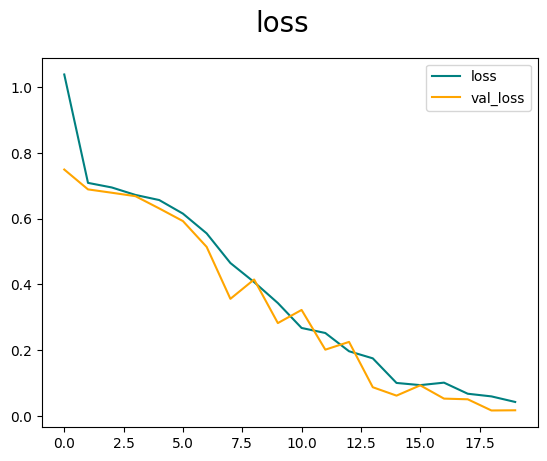

In [53]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper right')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

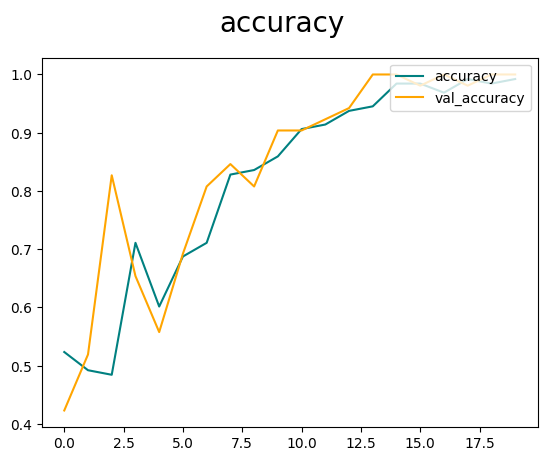

In [54]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show

In [55]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [56]:
for batch in test.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)

In [57]:
print(f"{pre.result().numpy()},{re.result().numpy()},{acc.result().numpy()}")

0.0,0.0,0.0


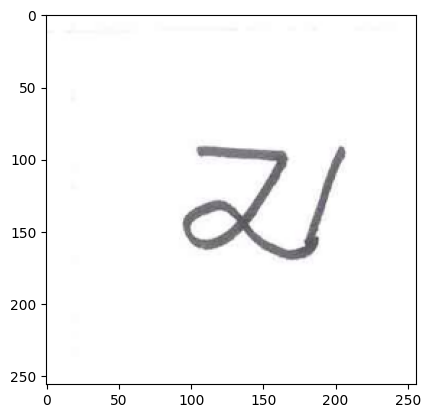

In [58]:
img = cv2.imread("/gdrive/MyDrive/Dataset/ca/ca.17.jpg")
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [59]:
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 [==============================] - 0s 227ms/step


array([[0.98130304]], dtype=float32)

In [60]:
if yhat > 0.5:
  print("Ini huruf ca")
else:
  print("Ini huruf ba")

Ini huruf ca


In [61]:
model.save(os.path.join('models','imageclaasifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


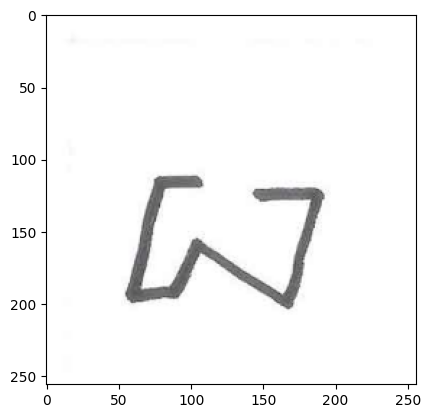

1/1 [==============================] - 0s 67ms/step
Ini huruf ba


In [64]:
new_model = load_model(os.path.join('models','imageclaasifier.h5'))
img = cv2.imread("/gdrive/MyDrive/Dataset/ba/ba.100.jpg")
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
yhat = new_model.predict(np.expand_dims(resize/255,0))
if yhat > 0.5:
  print("Ini huruf ca")
else:
  print("Ini huruf ba")